### Load Processed Data

In [1]:
import numpy as np
import pickle

# Load the arrays
train_x = np.load('../analysis-preprocessing/processed_data/train_x.npy')
test_x = np.load('../analysis-preprocessing/processed_data/test_x.npy')
train_y_pos = np.load('../analysis-preprocessing/processed_data/train_y_pos.npy')
test_y_pos = np.load('../analysis-preprocessing/processed_data/test_y_pos.npy')
train_y_ner = np.load('../analysis-preprocessing/processed_data/train_y_ner.npy')
test_y_ner = np.load('../analysis-preprocessing/processed_data/test_y_ner.npy')


# Load the vocab dictionaries
with open('../analysis-preprocessing/processed_data/words_vocab.pkl', 'rb') as f:
    words_vocab = pickle.load(f)

with open('../analysis-preprocessing/processed_data/pos_vocab.pkl', 'rb') as f:
    pos_vocab = pickle.load(f)

with open('../analysis-preprocessing/processed_data/ners_vocab.pkl', 'rb') as f:
    ners_vocab = pickle.load(f)

# Load the words, poss, and ners lists
with open('../analysis-preprocessing/processed_data/words.pkl', 'rb') as f:
    words = pickle.load(f)

with open('../analysis-preprocessing/processed_data/poss.pkl', 'rb') as f:
    poss = pickle.load(f)

with open('../analysis-preprocessing/processed_data/ners.pkl', 'rb') as f:
    ners = pickle.load(f)

# Define the number of unique words, POS tags, and NER tags
nbr_words = len(words_vocab)
nbr_pos = len(pos_vocab)
nbr_ners = len(ners_vocab)

# Define maximum sentence length
max_len = 25


### Building the model

In [2]:
# import classes
import tensorflow as tf
import random
from keras.layers import Dense, Embedding, LSTM, Input
from keras.models import Model
from keras.callbacks import EarlyStopping

In [3]:
# Set the seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [4]:
from keras import backend as K

# Clear previous session
K.clear_session()

In [5]:
print(f'vocab size = {len(words_vocab)}')
print(f'embedding size = {max_len}')
print(f'number of possible pos labels = {len(pos_vocab)}')
print(f'number of possible ner labels = {len(ners_vocab)}')

vocab size = 14510
embedding size = 25
number of possible pos labels = 15
number of possible ner labels = 21


### Test-Validation Split

In [6]:
from sklearn.model_selection import train_test_split
val_x, test_x, val_y_pos, test_y_pos, val_y_ner, test_y_ner = train_test_split(
    test_x, test_y_pos, test_y_ner, test_size=0.5, random_state=seed
)

In [7]:
# Print shapes to verify splits
print(f"Train X shape: {np.array(train_x).shape}")
print(f"Validation X shape: {np.array(val_x).shape}")
print(f"Test X shape: {np.array(test_x).shape}")
print(f"Train Y POS shape: {np.array(train_y_pos).shape}")
print(f"Validation Y POS shape: {np.array(val_y_pos).shape}")
print(f"Test Y POS shape: {np.array(test_y_pos).shape}")
print(f"Train Y NER shape: {np.array(train_y_ner).shape}")
print(f"Validation Y NER shape: {np.array(val_y_ner).shape}")
print(f"Test Y NER shape: {np.array(test_y_ner).shape}")

Train X shape: (3246, 25)
Validation X shape: (406, 25)
Test X shape: (406, 25)
Train Y POS shape: (3246, 25)
Validation Y POS shape: (406, 25)
Test Y POS shape: (406, 25)
Train Y NER shape: (3246, 25)
Validation Y NER shape: (406, 25)
Test Y NER shape: (406, 25)


In [8]:
print(f"Unique POS labels: {np.unique(np.concatenate(train_y_pos))}")
print(f"Unique NER labels: {np.unique(np.concatenate(train_y_ner))}")

print(f"Number of POS classes: {nbr_pos}")
print(f"Number of NER classes: {nbr_ners}")

Unique POS labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
Unique NER labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
Number of POS classes: 15
Number of NER classes: 21


### Model

In [9]:
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights for POS
class_weights_pos = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(nbr_pos),
    y=np.concatenate(train_y_pos)
)
class_weights_pos = dict(enumerate(class_weights_pos))

# Compute class weights for NER
class_weights_ner = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(nbr_ners),
    y=np.concatenate(train_y_ner)
)
class_weights_ner = dict(enumerate(class_weights_ner))

In [10]:
# Define the model
input_layer = Input(shape=(max_len,))
embedding_layer = Embedding(input_dim=nbr_words, output_dim=25, input_length=max_len)(input_layer)
lstm_layer = LSTM(units=100, activation='tanh', return_sequences=True, recurrent_dropout=0.1)(embedding_layer)

In [11]:
# Output layers for POS and NER
pos_output = Dense(nbr_pos, activation='softmax', name='pos_output')(lstm_layer)
ner_output = Dense(nbr_ners, activation='softmax', name='ner_output')(lstm_layer)

In [12]:
# Define the model with two outputs
model = Model(inputs=input_layer, outputs=[pos_output, ner_output])

# Compile the model
model.compile(optimizer="adam",
              loss={"pos_output": "sparse_categorical_crossentropy", "ner_output": "sparse_categorical_crossentropy"},
              metrics={"pos_output": "accuracy", "ner_output": "accuracy"})

print(model.summary())


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 25)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 25, 25)               362750    ['input_1[0][0]']             
                                                                                                  
 lstm (LSTM)                 (None, 25, 100)              50400     ['embedding[0][0]']           
                                                                                                  
 pos_output (Dense)          (None, 25, 15)               1515      ['lstm[0][0]']                
                                                                                             

In [13]:
# # Example of ensuring labels are correctly encoded
# def encode_labels(labels, vocab_size):
#     """Ensure all label values are within the range [0, vocab_size-1]."""
#     encoded_labels = np.clip(labels, 0, vocab_size - 1)
#     return encoded_labels

# # Apply this function to your labels
# train_y_pos = encode_labels(train_y_pos, nbr_pos)
# train_y_ner = encode_labels(train_y_ner, nbr_ners)
# test_y_pos = encode_labels(test_y_pos, nbr_pos)
# test_y_ner = encode_labels(test_y_ner, nbr_ners)

In [14]:
# Define early stopping
early_stopping = EarlyStopping(monitor='val_ner_output_accuracy', min_delta=0, patience=10, verbose=1, mode='max')

In [15]:
# Train the model
history = model.fit(train_x, 
                    {"pos_output": train_y_pos, "ner_output": train_y_ner},
                    validation_data=(val_x, {"pos_output": val_y_pos, "ner_output": val_y_ner}),
                    batch_size=32,
                    epochs=100,
                    callbacks=[early_stopping],
                    class_weight=None #{"pos_output": class_weights_pos, "ner_output": class_weights_ner}
                )

Epoch 1/100


102/102 [==============================] - 6s 29ms/step - loss: 2.9560 - pos_output_loss: 1.4914 - ner_output_loss: 1.4645 - pos_output_accuracy: 0.5836 - ner_output_accuracy: 0.6641 - val_loss: 2.1861 - val_pos_output_loss: 1.1754 - val_ner_output_loss: 1.0107 - val_pos_output_accuracy: 0.6925 - val_ner_output_accuracy: 0.8040
Epoch 2/100
102/102 [==============================] - 2s 20ms/step - loss: 1.8993 - pos_output_loss: 1.0389 - ner_output_loss: 0.8603 - pos_output_accuracy: 0.7193 - ner_output_accuracy: 0.8374 - val_loss: 1.8013 - val_pos_output_loss: 1.0052 - val_ner_output_loss: 0.7961 - val_pos_output_accuracy: 0.7187 - val_ner_output_accuracy: 0.8460
Epoch 3/100
102/102 [==============================] - 2s 20ms/step - loss: 1.6551 - pos_output_loss: 0.9323 - ner_output_loss: 0.7228 - pos_output_accuracy: 0.7290 - ner_output_accuracy: 0.8582 - val_loss: 1.6593 - val_pos_output_loss: 0.9449 - val_ner_output_loss: 0.7144 - val_pos_output_accuracy: 0.7259 - val_

In [16]:
history.history.keys()

dict_keys(['loss', 'pos_output_loss', 'ner_output_loss', 'pos_output_accuracy', 'ner_output_accuracy', 'val_loss', 'val_pos_output_loss', 'val_ner_output_loss', 'val_pos_output_accuracy', 'val_ner_output_accuracy'])

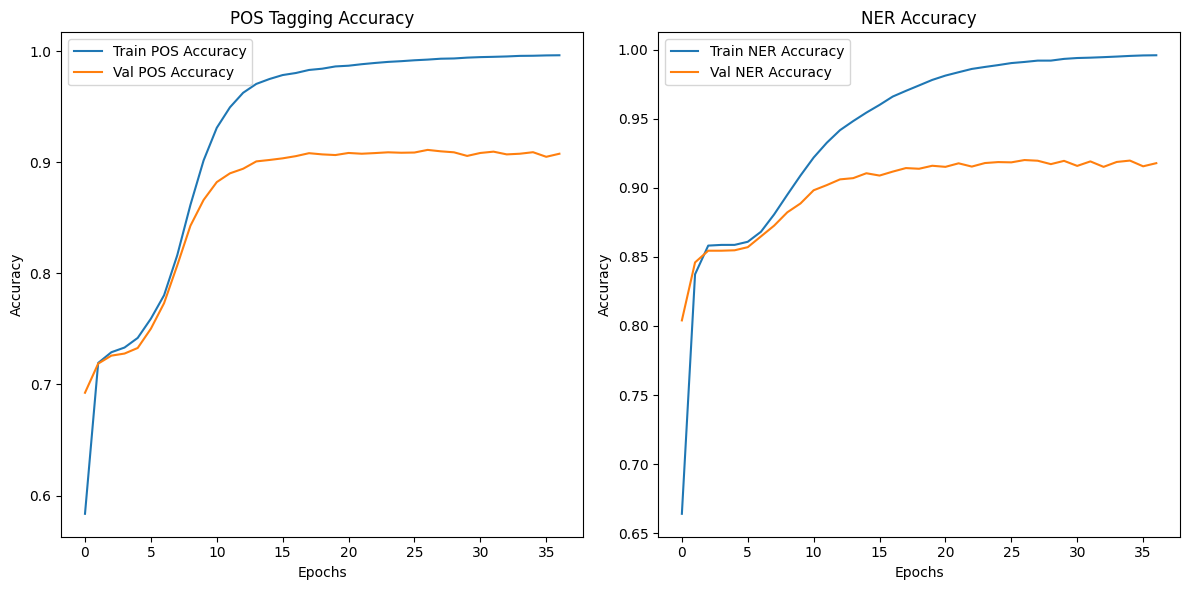

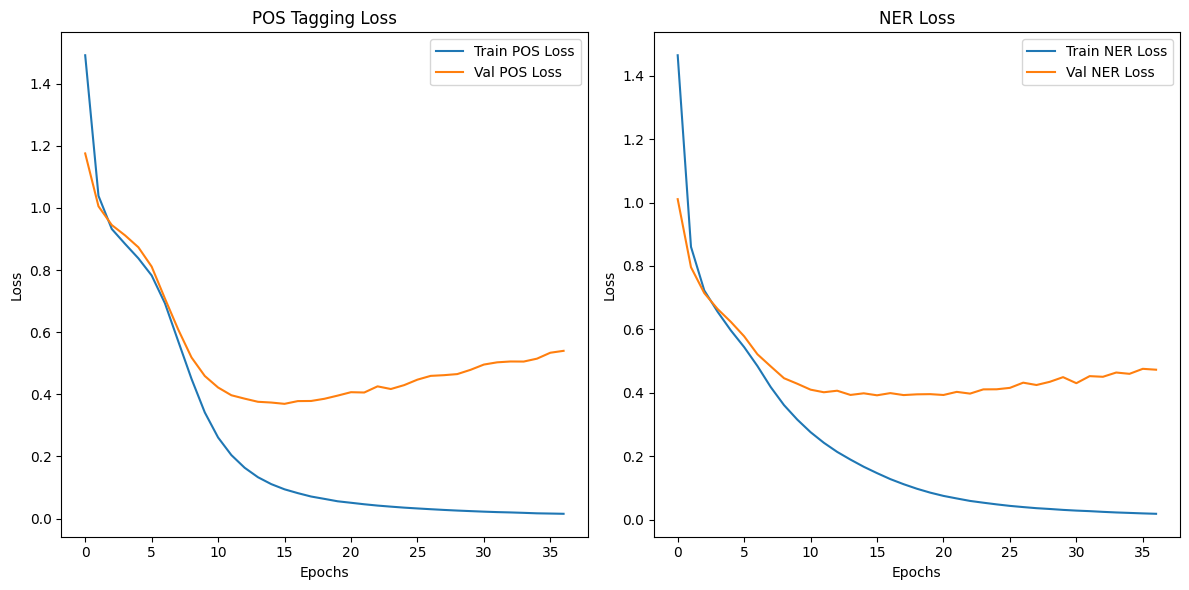

In [17]:
import matplotlib.pyplot as plt

# Extract training and validation metrics from the history object
history_dict = history.history

# Plot accuracy
plt.figure(figsize=(12, 6))

# Plot POS Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_dict['pos_output_accuracy'], label='Train POS Accuracy')
plt.plot(history_dict['val_pos_output_accuracy'], label='Val POS Accuracy')
plt.title('POS Tagging Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot NER Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_dict['ner_output_accuracy'], label='Train NER Accuracy')
plt.plot(history_dict['val_ner_output_accuracy'], label='Val NER Accuracy')
plt.title('NER Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Plot loss
plt.figure(figsize=(12, 6))

# Plot POS Loss
plt.subplot(1, 2, 1)
plt.plot(history_dict['pos_output_loss'], label='Train POS Loss')
plt.plot(history_dict['val_pos_output_loss'], label='Val POS Loss')
plt.title('POS Tagging Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot NER Loss
plt.subplot(1, 2, 2)
plt.plot(history_dict['ner_output_loss'], label='Train NER Loss')
plt.plot(history_dict['val_ner_output_loss'], label='Val NER Loss')
plt.title('NER Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


### Evaluate the model

In [18]:
# Evaluate the model on the test data
test_loss, test_pos_loss, test_ner_loss, test_pos_accuracy, test_ner_accuracy = model.evaluate(test_x, {"pos_output": test_y_pos, "ner_output": test_y_ner}, batch_size=128)
print(f"Test Loss: {test_loss}")
print(f"Test POS Loss: {test_pos_loss}")
print(f"Test NER Loss: {test_ner_loss}")
print(f"Test POS Accuracy: {test_pos_accuracy}")
print(f"Test NER Accuracy: {test_ner_accuracy}")

4/4 [==============================] - 0s 9ms/step - loss: 0.9369 - pos_output_loss: 0.4754 - ner_output_loss: 0.4615 - pos_output_accuracy: 0.9177 - ner_output_accuracy: 0.9187
Test Loss: 0.9369004964828491
Test POS Loss: 0.4754413068294525
Test NER Loss: 0.4614591896533966
Test POS Accuracy: 0.9177339673042297
Test NER Accuracy: 0.9187192320823669


In [19]:
from sklearn.metrics import classification_report, accuracy_score
# Make predictions on the test set
predictions = model.predict(test_x)

# Extract predictions for POS and NER based on their positions
pred_pos = np.argmax(predictions[0], axis=-1)
pred_ner = np.argmax(predictions[1], axis=-1)

# Convert test_y to the appropriate format
true_pos = np.array(test_y_pos)
true_ner = np.array(test_y_ner)

# Flatten the arrays for metric calculation
pred_pos_flat = pred_pos.flatten()
true_pos_flat = true_pos.flatten()
pred_ner_flat = pred_ner.flatten()
true_ner_flat = true_ner.flatten()

# Remove padding values from the flattened arrays for metrics calculation
valid_pos_indices = true_pos_flat != nbr_pos-1
valid_ner_indices = true_ner_flat != nbr_ners-1

# Filter out the padding values
true_pos_filtered = true_pos_flat[valid_pos_indices]
pred_pos_filtered = pred_pos_flat[valid_pos_indices]
true_ner_filtered = true_ner_flat[valid_ner_indices]
pred_ner_filtered = pred_ner_flat[valid_ner_indices]

13/13 [==============================] - 0s 5ms/step


In [20]:
# Calculate metrics for POS
pos_accuracy = accuracy_score(true_pos_filtered, pred_pos_filtered)
pos_classification_report = classification_report(true_pos_filtered, pred_pos_filtered, target_names=list(pos_vocab.keys()), zero_division=0)
print("POS Tagging Metrics:")
print(f"Accuracy: {pos_accuracy}")
print(f"\nClassification Report:\n {pos_classification_report}")

POS Tagging Metrics:
Accuracy: 0.8147405922957025

Classification Report:
               precision    recall  f1-score   support

         OTH       0.80      0.44      0.57         9
          VF       0.97      0.87      0.91       419
          PP       0.88      0.90      0.89       171
         DET       0.86      0.94      0.90        81
         PRO       0.94      0.89      0.91       123
         VNF       0.91      0.73      0.81       147
         ADV       0.86      0.71      0.78       145
         NNC       0.81      0.87      0.84      1770
         NNP       0.66      0.72      0.69       772
          QF       0.95      0.85      0.90       177
        PART       0.67      0.40      0.50         5
         ADJ       0.82      0.67      0.74       489
        CONJ       0.93      0.92      0.92        97
       PUNCT       1.00      0.79      0.88        86
        INTJ       0.00      0.00      0.00         0

    accuracy                           0.81      4491
   ma

In [21]:
# Calculate metrics for NER
ner_accuracy = accuracy_score(true_ner_filtered, pred_ner_filtered)
ner_classification_report = classification_report(true_ner_filtered, pred_ner_filtered, zero_division=0)

print("NER Tagging Metrics:")
print(f"Accuracy: {ner_accuracy}")
print(f"\nClassification Report:\n {ner_classification_report}")

NER Tagging Metrics:
Accuracy: 0.8181209551439411

Classification Report:
               precision    recall  f1-score   support

           0       0.52      0.47      0.49       159
           1       0.75      0.55      0.63       382
           2       0.78      0.55      0.65        94
           4       0.56      0.39      0.46        23
           5       0.00      0.00      0.00         8
           6       0.88      0.94      0.91      3050
           7       1.00      0.70      0.82        23
           8       0.66      0.57      0.62       162
           9       0.35      0.46      0.40        26
          10       0.00      0.00      0.00         0
          11       0.00      0.00      0.00         3
          12       0.48      0.41      0.45       104
          13       0.87      0.85      0.86        96
          14       0.45      0.78      0.57        23
          15       0.91      0.81      0.86       126
          16       0.83      0.90      0.86        60
      

In [22]:
model.save("../models_evaluation/models/base_model.h5")

c:\Users\UTSHAB\anaconda3\envs\end-to-end-nlp-practice\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Hyperparameters Tuning

In [16]:
import keras_tuner as kt
from keras.callbacks import ModelCheckpoint

In [17]:
def build_model(hp):
    input_layer = Input(shape=(max_len,))
    
    # Hyperparameters for embedding
    embedding_dim = hp.Int('embedding_dim', min_value=10, max_value=50, step=10, default=25)
    embedding_layer = Embedding(input_dim=nbr_words, output_dim=embedding_dim, input_length=max_len)(input_layer)
    
    # Hyperparameters for LSTM
    lstm_units = hp.Int('lstm_units', min_value=50, max_value=200, step=50, default=100)
    recurrent_dropout = hp.Float('recurrent_dropout', min_value=0.1, max_value=0.5, step=0.1, default=0.1)
    lstm_layer = LSTM(units=lstm_units, activation='tanh', return_sequences=True, recurrent_dropout=recurrent_dropout)(embedding_layer)
    
    # Output layers for POS and NER
    pos_output = Dense(nbr_pos, activation='softmax', name='pos_output')(lstm_layer)
    ner_output = Dense(nbr_ners, activation='softmax', name='ner_output')(lstm_layer)
    
    # Define the model with two outputs
    model = Model(inputs=input_layer, outputs=[pos_output, ner_output])
    
    # Compile the model with learning rate hyperparameter
    learning_rate = hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='log', default=1e-3)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss={"pos_output": "sparse_categorical_crossentropy", "ner_output": "sparse_categorical_crossentropy"},
                  metrics={"pos_output": "accuracy", "ner_output": "accuracy"})
    
    return model

In [18]:
# Define the checkpoint callback
checkpoint = ModelCheckpoint(
    '../models/best_model.h5',  # Path where the model will be saved
    monitor='val_ner_output_accuracy',  # Metric to monitor
    save_best_only=True,  # Save only the best model
    mode='max',  # Mode for monitoring (maximize accuracy)
    verbose=1  # Verbosity mode
)


In [19]:
early_stopping = EarlyStopping(
    monitor='val_ner_output_accuracy',  # Metric to monitor
    patience=5,  # Number of epochs with no improvement after which training will be stopped
    verbose=1,  # Verbosity mode
    mode='max',  # Mode for monitoring (maximize accuracy)
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored metric
)

In [20]:
# Define the objective for the tuner
objective = kt.Objective("val_ner_output_accuracy", direction="max")

In [21]:
from keras_tuner import Hyperband
from keras_tuner.tuners import BayesianOptimization

# # Define the hyperparameter tuner
# tuner = Hyperband(
#     build_model,  # Function to build the model
#     objective=objective,  # Specify the objective with direction
#     max_epochs=100,
#     hyperband_iterations=10,
#     directory='../models',  # Main directory for tuning results
#     project_name='hyperparameter_tuning'  # Project subdirectory
# )
tuner = BayesianOptimization(
    build_model,  # Function to build the model
    objective=objective,  # Specify the objective with direction
    max_trials=50,  # Number of trials to run
    executions_per_trial=3,  # Number of executions per trial
    directory='../models',  # Main directory for tuning results
    project_name='bayesian_optimization'  # Project subdirectory
)

In [22]:
# Run the hyperparameter search
tuner.search(
    train_x, 
    {"pos_output": train_y_pos, "ner_output": train_y_ner},
    validation_data=(val_x, {"pos_output": val_y_pos, "ner_output": val_y_ner}),
    batch_size=32,
    epochs=50,
    callbacks=[checkpoint, early_stopping]  # Add the checkpoint callback here
)

Trial 50 Complete [00h 03m 13s]
val_ner_output_accuracy: 0.9225287238756815

Best val_ner_output_accuracy So Far: 0.9284072319666544
Total elapsed time: 03h 55m 23s


In [23]:
# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best Hyperparameters:")
print(f"Embedding Dimension: {best_hps.get('embedding_dim')}")
print(f"LSTM Units: {best_hps.get('lstm_units')}")
print(f"Recurrent Dropout: {best_hps.get('recurrent_dropout')}")
print(f"Learning Rate: {best_hps.get('learning_rate')}")

Best Hyperparameters:
Embedding Dimension: 40
LSTM Units: 200
Recurrent Dropout: 0.5
Learning Rate: 0.01


In [24]:
# Save metrics to a text file
with open('../models/parameters_track/parameters_bayesian.txt', 'w') as file:
    # Write POS metrics
    file.write("Best Hyperparameters:\n")
    file.write(f"Embedding Dimension: {best_hps.get('embedding_dim')}\n")
    file.write(f"LSTM Units: {best_hps.get('lstm_units')}\n")
    file.write(f"Recurrent Dropout: {best_hps.get('recurrent_dropout')}\n")
    file.write(f"Learning Rate: {best_hps.get('learning_rate')}\n")

print("Parameters have been saved to '../models/parameters_track/parameters_bayesian_1.txt'.")

Parameters have been saved to '../models/parameters_track/parameters_bayesian_1.txt'.


In [25]:
# # Save metrics to a text file
# with open('../reports/score_2_resampling.txt', 'w') as file:
#     # Write POS metrics
#     file.write("POS Tagging Metrics:\n")
#     file.write(f"Accuracy: {pos_accuracy}\n\n")
#     file.write("Classification Report:\n")
#     file.write(pos_classification_report)
    
#     # Write NER metrics
#     file.write("\nNER Tagging Metrics:\n")
#     file.write(f"Accuracy: {ner_accuracy}\n\n")
#     file.write("Classification Report:\n")
#     file.write(ner_classification_report)

# print("Metrics have been saved to '../reports/metrics.txt'.")